In [1]:
from neurovelo.train import Trainer
from neurovelo.utils import ModelAnalyzer,latent_data,evaluate,decode_gene_velocity,vector_fields_similarity
import scvelo as scv
import scanpy as sc
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
adata = scv.datasets.bonemarrow()

Do all preprocessing before running the method.

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 7837 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


2024-06-12 14:35:27.032153: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 14:35:27.071505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 14:35:29.354313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished (0:00:16) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


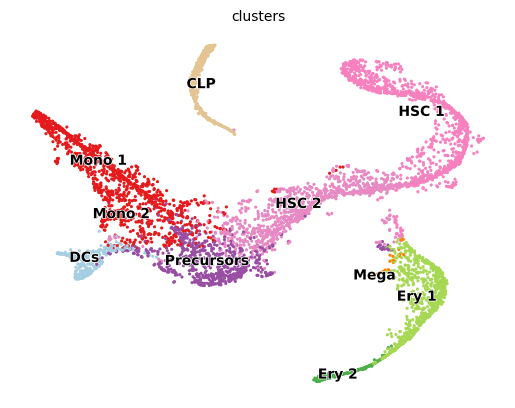

In [6]:
scv.pl.tsne(adata, color='clusters')

**NeuroVelo takes "sample" obs to learn sample specific dynamics. If you want to train for global dynamics of your dataset. Create a sample obs and set it to zero as shown here**

In [7]:
adata.obs['sample'] = 0

***You can pass in layer argument whether you want to use moments (pass 'Ms') or reads (pass 'spliced').
You can also pass all the usual argument to train a neural network.***

In [8]:
model = Trainer(adata,layer='Ms', odesample_obs = 'sample', n_sample=1, percent=0.8,nepoch=300)
model.train()

Using spliced and unspliced moments


Epoch 300: 100%|█████████████████████████████████| 300/300 [10:15<00:00,  2.05s/epoch, train_loss=0.745, val_loss=0.715]


In [9]:
model.save_model('./trained_models/','hbm_trained_model_Ms')

In [10]:
latent_adata = latent_data(adata,'./trained_models/hbm_trained_model_Ms.pth', layer='Ms')

In [11]:
scv.pp.neighbors(latent_adata, n_neighbors=30)
latent_adata.obsm['X_tsne'] = adata.obsm['X_tsne']

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


Sometimes we might end up in a reverse direction as we don't give any initial condition on where the initial point should be, in that case, reversing the velocity should be enough

In [12]:
reverse = True
if reverse:
    latent_adata.layers['spliced_velocity'] = -latent_adata.layers['spliced_velocity']

# Velocity in latent and gene space

Since our embedding in a linear embedding, the latent and gene space velocity should be similar, if you notice that they are different, try different set of parameters as this suggest that the decoder did not find an optimal reconsutrction.
### Velocity in Latent space

computing velocity graph (using 1/112 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


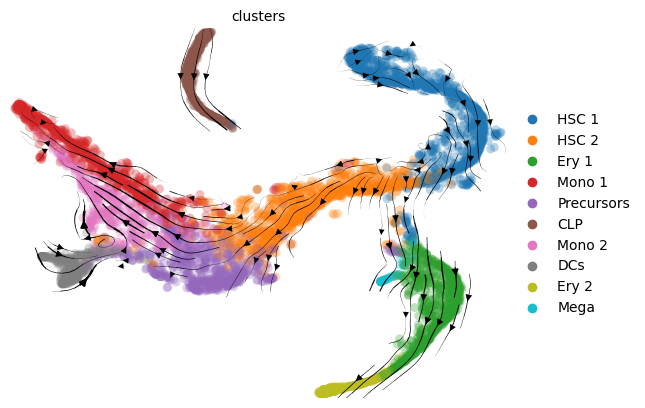

In [13]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity', xkey='Ms')
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='tsne')
scv.pl.velocity_embedding_stream(latent_adata,basis='tsne',vkey='spliced_velocity', color='clusters',legend_loc='far right')

### Velocity in gene space

In [14]:
adata.layers['spliced_velocity'] = decode_gene_velocity(adata,'./trained_models/hbm_trained_model_Ms.pth', layer='Ms')
if reverse:
    print("reversing velocity")
    adata.layers['spliced_velocity'] = -adata.layers['spliced_velocity']

reversing velocity


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/112 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:32) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


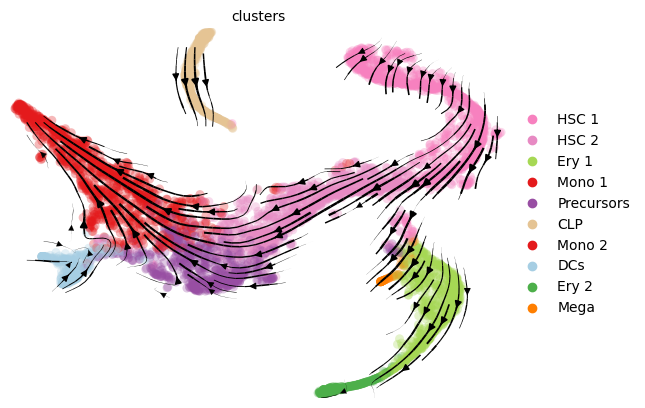

In [15]:
scv.pp.neighbors(adata)
scv.tl.velocity_graph(adata, vkey='spliced_velocity', xkey='Ms')
scv.tl.velocity_embedding(adata, vkey='spliced_velocity', basis='tsne')
scv.pl.velocity_embedding_stream(adata,basis='tsne',vkey='spliced_velocity', color='clusters',legend_loc='far right')

#### The evaluate function is the same of UniTVelo, it measures Cross boundary direction and In-Cluster coherence. The cluster edges should contain the direction from A->B ("A", "B"), we evaluate it for both velocity in latent space (latent_adata) and velocity in gene space (adata)

In [16]:
cluster_edges = [
    ("HSC_1", "Ery_1"), 
    ("HSC_1", "HSC_2"), 
    ("Ery_1", "Ery_2")]

In [17]:
evaluate(latent_adata, cluster_edges, 'clusters','spliced_velocity',x_emb='X_tsne')

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): 0.4714356696018027, ('HSC_1', 'HSC_2'): 0.11943636254118811, ('Ery_1', 'Ery_2'): 0.5571966668081483}
Total Mean: 0.38268956631704637
# In-cluster Coherence
{'CLP': 0.999970404016315, 'DCs': 0.9999424897568925, 'Ery_1': 0.9999863758568781, 'Ery_2': 0.9999768679512058, 'HSC_1': 0.9999826015585794, 'HSC_2': 0.9999826362172862, 'Mega': 0.9999799649849148, 'Mono_1': 0.999985536839436, 'Mono_2': 0.9999875956984788, 'Precursors': 0.9999839105700832}
Total Mean: 0.9999778383450071


{'Cross-Boundary Direction Correctness (A->B)': ({('HSC_1',
    'Ery_1'): 0.4714356696018027,
   ('HSC_1', 'HSC_2'): 0.11943636254118811,
   ('Ery_1', 'Ery_2'): 0.5571966668081483},
  0.38268956631704637),
 'In-cluster Coherence': ({'CLP': 0.999970404016315,
   'DCs': 0.9999424897568925,
   'Ery_1': 0.9999863758568781,
   'Ery_2': 0.9999768679512058,
   'HSC_1': 0.9999826015585794,
   'HSC_2': 0.9999826362172862,
   'Mega': 0.9999799649849148,
   'Mono_1': 0.999985536839436,
   'Mono_2': 0.9999875956984788,
   'Precursors': 0.9999839105700832},
  0.9999778383450071)}

In [18]:
evaluate(adata, cluster_edges, 'clusters','spliced_velocity',x_emb='X_tsne')

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): 0.817145222140625, ('HSC_1', 'HSC_2'): 0.764372939159443, ('Ery_1', 'Ery_2'): 0.8618396878308829}
Total Mean: 0.8144526163769837
# In-cluster Coherence
{'CLP': 0.99981904, 'DCs': 0.99874616, 'Ery_1': 0.99947166, 'Ery_2': 0.9995253, 'HSC_1': 0.9994255, 'HSC_2': 0.99862623, 'Mega': 0.99901056, 'Mono_1': 0.9995935, 'Mono_2': 0.999406, 'Precursors': 0.99876904}
Total Mean: 0.9992392659187317


{'Cross-Boundary Direction Correctness (A->B)': ({('HSC_1',
    'Ery_1'): 0.817145222140625,
   ('HSC_1', 'HSC_2'): 0.764372939159443,
   ('Ery_1', 'Ery_2'): 0.8618396878308829},
  0.8144526163769837),
 'In-cluster Coherence': ({'CLP': 0.99981904,
   'DCs': 0.99874616,
   'Ery_1': 0.99947166,
   'Ery_2': 0.9995253,
   'HSC_1': 0.9994255,
   'HSC_2': 0.99862623,
   'Mega': 0.99901056,
   'Mono_1': 0.9995935,
   'Mono_2': 0.999406,
   'Precursors': 0.99876904},
  0.99923927)}

# Trained models evaluation

In [19]:
adata = scv.datasets.bonemarrow()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
sc.pp.log1p(adata, layer='spliced')
sc.pp.log1p(adata, layer='unspliced')

Filtered out 7837 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [20]:
adata.obs['sample'] = 0

In [27]:
zspliced_models = glob.glob('./trained_models/bonemarrow_zt/*layer_spliced*')
zmoments_models = glob.glob('./trained_models/bonemarrow_zt/*layer_Ms*')
xspliced_models = glob.glob('./trained_models/bonemarrow_xt/*layer_spliced*')
xmoments_models = glob.glob('./trained_models/bonemarrow_xt/*layer_Ms*')

In [28]:
zmoments_cos_sim, zmoments_mean = vector_fields_similarity(adata, zmoments_models, layer="Ms")
zspliced_cos_sim, zspliced_mean = vector_fields_similarity(adata, zspliced_models, layer="spliced")
xmoments_cos_sim, xmoments_mean = vector_fields_similarity(adata, xmoments_models, layer="Ms")
xspliced_cos_sim, xspliced_mean = vector_fields_similarity(adata, xspliced_models, layer="spliced")

([<matplotlib.axis.XTick at 0x7f5802b0e6a0>,
 [Text(0, 0, 'z_moments'),
  Text(1, 0, 'z_normalized reads'),
  Text(2, 0, 'x_moments'),
  Text(3, 0, 'x_normalized reads')])

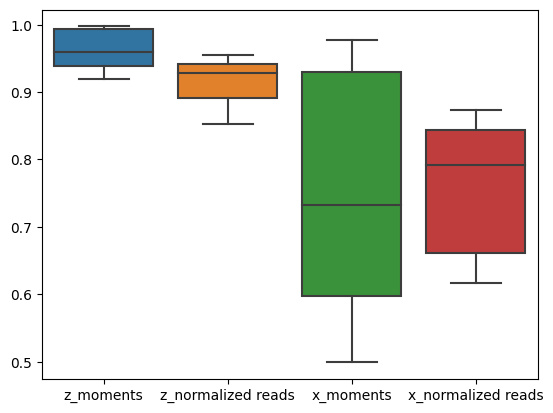

In [29]:
sns.boxplot([list(zmoments_cos_sim.values()), list(zspliced_cos_sim.values()),
             list(xmoments_cos_sim.values()), list(xspliced_cos_sim.values())])
plt.xticks([0,1,2,3],['z_moments','z_normalized reads','x_moments','x_normalized reads'])

### For the rest of analysis, we are taking the model trained using moments instead of reads and it reconstructs $z(t)$ instead of $x(t)$ as it shows more rubstness

./trained_models/bonemarrow_zt/layer_Ms_bonemarrow_nv_123.pth
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/112 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:36) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


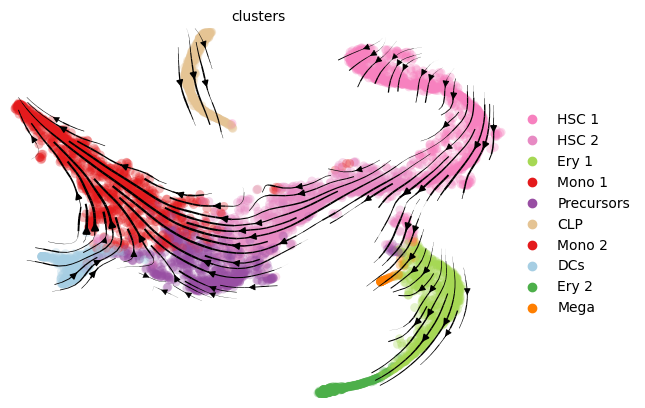

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): 0.8438199653984274, ('HSC_1', 'HSC_2'): 0.7510119539769003, ('Ery_1', 'Ery_2'): 0.8750603534013259}
Total Mean: 0.8232974242588845
# In-cluster Coherence
{'CLP': 0.9988746, 'DCs': 0.9948612, 'Ery_1': 0.9983601, 'Ery_2': 0.9981105, 'HSC_1': 0.9960948, 'HSC_2': 0.9953806, 'Mega': 0.9979142, 'Mono_1': 0.99818224, 'Mono_2': 0.9974661, 'Precursors': 0.99556375}
Total Mean: 0.9970808029174805
./trained_models/bonemarrow_zt/layer_Ms_bonemarrow_nv_124.pth
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/112 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:37) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


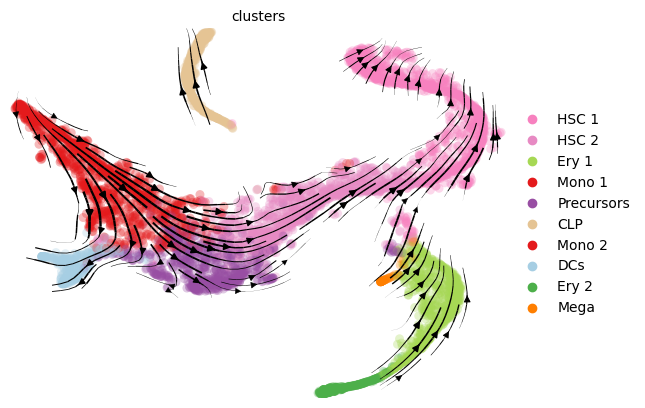

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): -0.8576917169941057, ('HSC_1', 'HSC_2'): -0.7338613826959086, ('Ery_1', 'Ery_2'): -0.8514527816128699}
Total Mean: -0.8143352937676281
# In-cluster Coherence
{'CLP': 0.99970174, 'DCs': 0.99543464, 'Ery_1': 0.99936, 'Ery_2': 0.9991912, 'HSC_1': 0.9992785, 'HSC_2': 0.9971103, 'Mega': 0.99945796, 'Mono_1': 0.99783546, 'Mono_2': 0.99590296, 'Precursors': 0.99485}
Total Mean: 0.9978122711181641
./trained_models/bonemarrow_zt/layer_Ms_bonemarrow_nv_125.pth
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/112 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:40) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


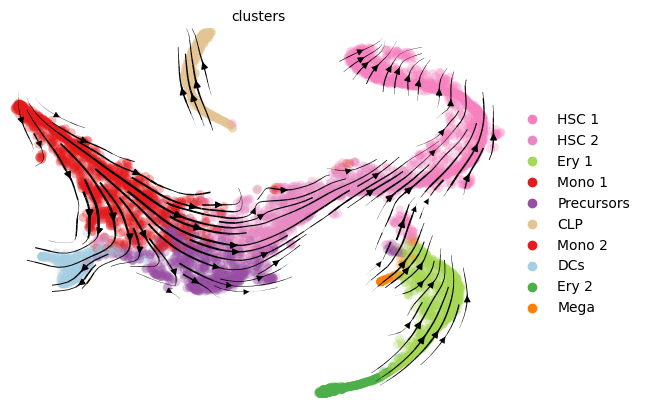

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): -0.854001207366311, ('HSC_1', 'HSC_2'): -0.7338538733605895, ('Ery_1', 'Ery_2'): -0.8546093186674475}
Total Mean: -0.814154799798116
# In-cluster Coherence
{'CLP': 0.9994663, 'DCs': 0.9949252, 'Ery_1': 0.9993176, 'Ery_2': 0.99917763, 'HSC_1': 0.9991446, 'HSC_2': 0.9970391, 'Mega': 0.9994668, 'Mono_1': 0.99833554, 'Mono_2': 0.99647164, 'Precursors': 0.9952747}
Total Mean: 0.9978618621826172
./trained_models/bonemarrow_zt/layer_Ms_bonemarrow_nv_126.pth
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/112 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:36) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


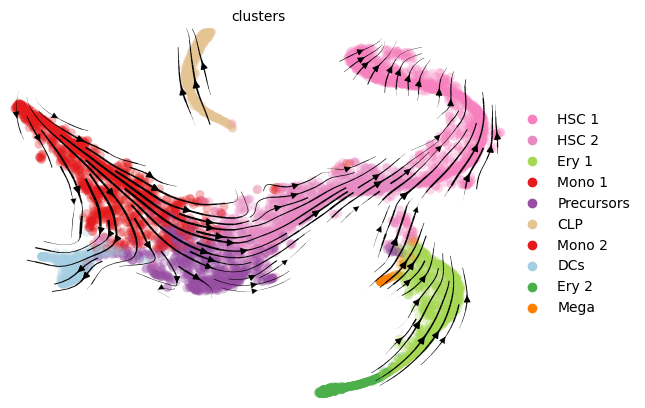

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): -0.8581503632757977, ('HSC_1', 'HSC_2'): -0.7329503678225878, ('Ery_1', 'Ery_2'): -0.8698127045500633}
Total Mean: -0.820304478549483
# In-cluster Coherence
{'CLP': 0.99943286, 'DCs': 0.99475974, 'Ery_1': 0.9990491, 'Ery_2': 0.99811876, 'HSC_1': 0.9990114, 'HSC_2': 0.9968804, 'Mega': 0.99907345, 'Mono_1': 0.99705195, 'Mono_2': 0.9943779, 'Precursors': 0.9942651}
Total Mean: 0.9972020983695984
./trained_models/bonemarrow_zt/layer_Ms_bonemarrow_nv_127.pth
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/112 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:35) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


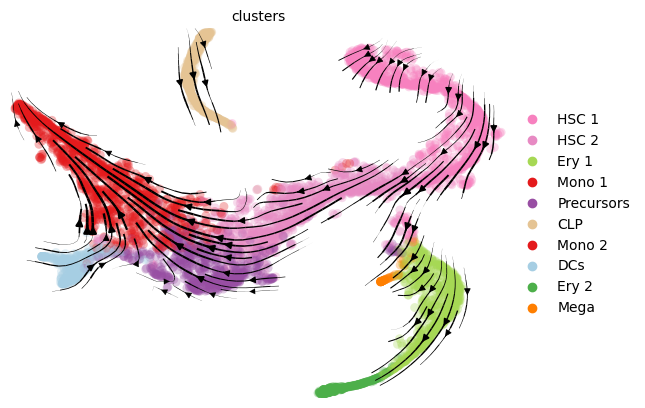

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): 0.8404811484117704, ('HSC_1', 'HSC_2'): 0.7484908563820694, ('Ery_1', 'Ery_2'): 0.8750789868143413}
Total Mean: 0.8213503305360602
# In-cluster Coherence
{'CLP': 0.9983122, 'DCs': 0.9934102, 'Ery_1': 0.99740344, 'Ery_2': 0.99737823, 'HSC_1': 0.9945293, 'HSC_2': 0.9941205, 'Mega': 0.99657303, 'Mono_1': 0.9982467, 'Mono_2': 0.99716324, 'Precursors': 0.99502987}
Total Mean: 0.9962165951728821
./trained_models/bonemarrow_zt/layer_Ms_bonemarrow_nv_128.pth
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/112 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:39) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'spliced_velocity_tsne', embedded velocity vectors (adata.obsm)


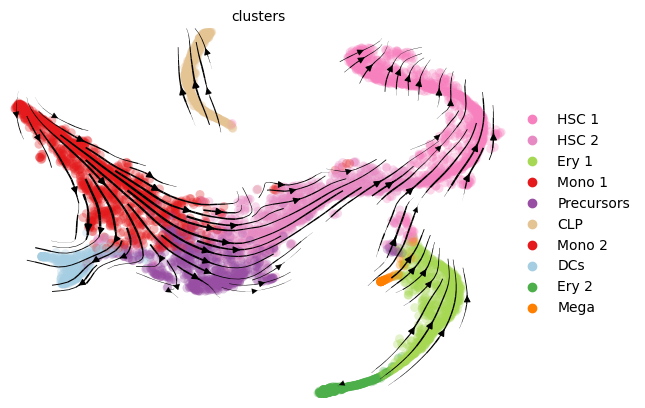

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): -0.8554203681734165, ('HSC_1', 'HSC_2'): -0.7325816427826866, ('Ery_1', 'Ery_2'): -0.8398768754940131}
Total Mean: -0.8092929621500388
# In-cluster Coherence
{'CLP': 0.9995294, 'DCs': 0.99542904, 'Ery_1': 0.99943376, 'Ery_2': 0.99929243, 'HSC_1': 0.9992913, 'HSC_2': 0.997065, 'Mega': 0.9994868, 'Mono_1': 0.99758404, 'Mono_2': 0.9952105, 'Precursors': 0.99461734}
Total Mean: 0.9976938962936401


In [30]:
for m in zmoments_models:
    print(m)
    adata.layers['spliced_velocity'] = decode_gene_velocity(adata,m, layer='Ms')
    scv.pp.neighbors(adata)
    scv.tl.velocity_graph(adata, vkey='spliced_velocity', xkey='Ms')
    scv.tl.velocity_embedding(adata, vkey='spliced_velocity', basis='tsne')
    scv.pl.velocity_embedding_stream(adata,basis='tsne',vkey='spliced_velocity', color='clusters',legend_loc='far right')
    evaluate(adata, cluster_edges, 'clusters','spliced_velocity',x_emb='X_tsne')

# Trained models analysis

In [31]:
adata.obs['treatment'] = 'no_treatment'

In [32]:
analyzer = ModelAnalyzer(data=adata, n_vectors=25, layer='Ms', models_path=zmoments_models)
results = analyzer.models_output()
gene_ranking_order, gene_ranking_mean = analyzer.gene_ranking()

You can take this list of genes and pass it to https://string-db.org/, which is a database for protein interaction. You can also download the network coordinate and pass it through our ```graph_maker.plot_custom_graph``` method for the same visualization

In [33]:
 #List of important genes for the dynamics
for g in gene_ranking_order['no_treatment'][0][:15].values:
    print(g)

IGLL1
MALAT1
CD79B
MPO
VPREB3
ELANE
VPREB1
CD74
LAPTM5
PRTN3
CD9
AZU1
AKAP12
CXCR4
FOS


In [34]:
from neurovelo.grn import GraphMaker
import numpy as np

In [36]:
graph_maker = GraphMaker(adata, np.random.choice(zmoments_models), layer='Ms')

In [37]:
genes_of_interest = gene_ranking_order['no_treatment'][0][:15].values  # List of genes you're interested in
n_frames = 30  # Number of frames for the analysis
take_windows = False  # Whether to take windows
ci = 0  # Start index for cell of ptime
take_smallest_ptime = False  # Whether to take smallest ptime cells

# Call the graph_maker method
A, gi, g, mean_ptime, sorted_cell_value, cell_of_ptime = graph_maker.graph_maker(
    genes_of_interest,
)

In [38]:
# Step 3: Create the graph
threshold_a = 0.3  # Threshold for significant connections
G = graph_maker.create_graph(A, gi, g, threshold_a)

The following genes are either not protein coding genes or not found in string-db:  ['MALAT1']


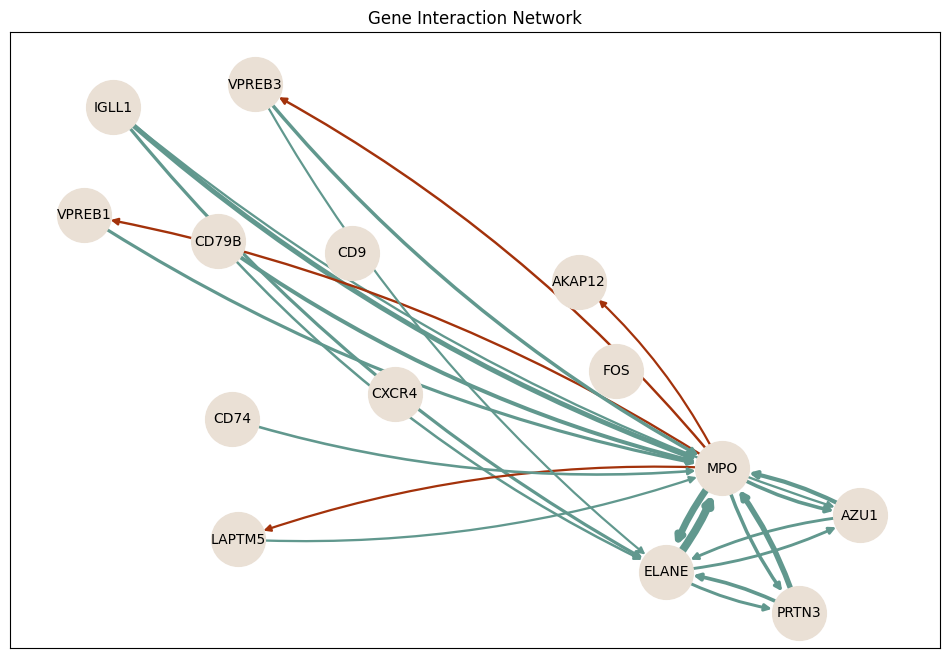

In [39]:
# Step 4: Plot the graph
graph_maker.plot_custom_graph(G,edge_width=5, network_node_file='network_coordinate/human_bone_marrow_string_network_coordinates.tsv')

## Network from stringdb

<img src="stringdb_network/string_normal_image_human_bonemarrow.png">